In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import text, sequence
from sklearn.preprocessing import scale
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
from keras.losses import binary_crossentropy
from keras import backend as K

Embedding_Files = ['D:/Kaggle Projects/Unintended Bias in Toxicity Classification/Embedding Files/crawl-300d-2M.vec', 
                   'D:/Kaggle Projects/Unintended Bias in Toxicity Classification/Embedding Files/glove.840B.300d']
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


In [85]:
#df_test.drop(['created_date'], axis=1,inplace=True)
#df_test.fillna(0, inplace=True)
df_test = pd.read_csv('D:/390 Project/S&P/test.csv')
df_train = pd.read_csv('D:/390 Project/S&P/train.csv')

df_train.fillna(0, inplace=True)
df_train.drop(['id','created_date','parent_id', 'publication_id', 'article_id', 'rating', 'identity_annotator_count', 'toxicity_annotator_count'], axis=1,inplace=True)

In [86]:
print('Are there any NaNs?',df_train.isnull().values.any())
print(df_train.isna().sum())
print(df_train.dtypes,'\n')
print(df_train.describe())

Are there any NaNs? False
target                                 0
comment_text                           0
severe_toxicity                        0
obscene                                0
identity_attack                        0
insult                                 0
threat                                 0
asian                                  0
atheist                                0
bisexual                               0
black                                  0
buddhist                               0
christian                              0
female                                 0
heterosexual                           0
hindu                                  0
homosexual_gay_or_lesbian              0
intellectual_or_learning_disability    0
jewish                                 0
latino                                 0
male                                   0
muslim                                 0
other_disability                       0
other_gender                   

In [87]:
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(df_train) + list(df_test))
#df_train = tokenizer.texts_to_sequences(df_train)
#df_test = tokenizer.texts_to_sequences(df_test)
#df_train = sequence.pad_sequences(df_train, maxlen=220)
#df_test = sequence.pad_sequences(df_test, maxlen=220)

In [88]:
x = df_train
x.drop(['comment_text'], axis = 1, inplace=True)
data_scaled = pd.DataFrame(scale(x), columns = x.columns)
scaler = StandardScaler()
x = scaler.fit_transform(x)
pca = PCA()
PCs = pca.fit_transform(x)
PCs.shape
varRatio = pca.explained_variance_ratio_
print('Components:\n',pca.components_)
print('Explained Variance Results:\n',pca.explained_variance_)
print('Explained Variance Ratio:\n',pca.explained_variance_ratio_ * 100)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Components:
 [[ 4.81016348e-01  3.12758901e-01  3.10489378e-01 ...  1.85252974e-02
   2.14639464e-02  2.13015085e-01]
 [-2.41676441e-01 -1.73235838e-01 -2.78599639e-01 ...  3.03997239e-02
   2.08198102e-02 -1.07049868e-01]
 [ 9.74693779e-03 -1.82572734e-02 -3.32222803e-02 ...  4.38862328e-01
   5.74547473e-01 -4.14857454e-02]
 ...
 [ 7.43683160e-02  2.56510775e-01 -6.20354808e-01 ...  9.70297854e-03
  -2.86521178e-02  3.16692490e-01]
 [-1.08598818e-01 -1.73290691e-01  3.30309216e-01 ...  1.27535393e-02
   8.92738095e-03 -1.34335427e-01]
 [-7.46283741e-01 -7.76221770e-03  5.56408573e-02 ...  3.55330871e-04
  -1.47703678e-04  5.65397749e-02]]
Explained Variance Results:
 [3.16241816 2.03799777 1.71771514 1.54942724 1.47941975 1.3248856
 1.29108983 1.14500267 1.09954298 1.02612991 1.0195013  0.996301
 0.9787017  0.95553207 0.94342057 0.93373926 0.92078859 0.90636614
 0.89422323 0.89055019 0.87192541 0.8574226  0.83549965 0.82852432
 0.82192911 0.7798459  0.7552123  0.72124747 0.68509267 0

In [89]:
X = []
print(df_train)
for i in range(len(df_train)):
    X.append(df_train.iloc[i].values)
X = np.array(X)

y = []
for i in range (len(df_train)):
    if (X[i][0] >= .5):
        y.append(1)
    else:
        y.append(0)
y = np.array(y)

           target  severe_toxicity   obscene  identity_attack    insult  \
0        0.000000         0.000000  0.000000         0.000000  0.000000   
1        0.000000         0.000000  0.000000         0.000000  0.000000   
2        0.000000         0.000000  0.000000         0.000000  0.000000   
3        0.000000         0.000000  0.000000         0.000000  0.000000   
4        0.893617         0.021277  0.000000         0.021277  0.872340   
5        0.666667         0.047619  0.638095         0.000000  0.333333   
6        0.457627         0.050847  0.305085         0.000000  0.254237   
7        0.000000         0.000000  0.000000         0.000000  0.000000   
8        0.000000         0.000000  0.000000         0.000000  0.000000   
9        0.000000         0.000000  0.000000         0.000000  0.000000   
10       0.000000         0.000000  0.000000         0.000000  0.000000   
11       0.440000         0.000000  0.293333         0.000000  0.320000   
12       0.000000        

Feature ranking:
1. feature 0 (0.547541)
2. feature 4 (0.322405)
3. feature 2 (0.044870)
4. feature 3 (0.032773)
5. feature 5 (0.016677)
6. feature 1 (0.011279)
7. feature 35 (0.010734)
8. feature 29 (0.002163)
9. feature 9 (0.001506)
10. feature 33 (0.001446)
11. feature 20 (0.000974)
12. feature 34 (0.000937)
13. feature 15 (0.000926)
14. feature 19 (0.000741)
15. feature 30 (0.000683)
16. feature 12 (0.000676)
17. feature 32 (0.000520)
18. feature 11 (0.000494)
19. feature 31 (0.000351)
20. feature 23 (0.000268)
21. feature 27 (0.000259)
22. feature 24 (0.000220)
23. feature 17 (0.000214)
24. feature 6 (0.000172)
25. feature 18 (0.000165)
26. feature 28 (0.000157)
27. feature 25 (0.000140)
28. feature 13 (0.000127)
29. feature 26 (0.000091)
30. feature 16 (0.000091)
31. feature 8 (0.000090)
32. feature 21 (0.000083)
33. feature 22 (0.000079)
34. feature 7 (0.000062)
35. feature 10 (0.000044)
36. feature 14 (0.000040)


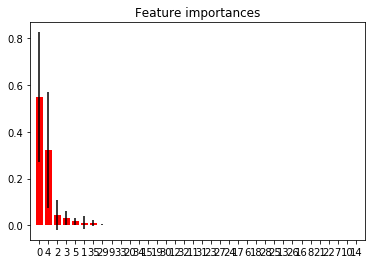

In [90]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [91]:
identities = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identities + ['target']:
    df_train[col] = np.select([df_train[col] >= 0.5], [True], default = False)
    identities = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identities + ['target']:
    df_train[col] = np.select([df_train[col] >= 0.5], [True], default = False)

In [92]:
print(df_train)

         target  severe_toxicity   obscene  identity_attack    insult  threat  \
0         False         0.000000  0.000000         0.000000  0.000000     0.0   
1         False         0.000000  0.000000         0.000000  0.000000     0.0   
2         False         0.000000  0.000000         0.000000  0.000000     0.0   
3         False         0.000000  0.000000         0.000000  0.000000     0.0   
4          True         0.021277  0.000000         0.021277  0.872340     0.0   
5          True         0.047619  0.638095         0.000000  0.333333     0.0   
6         False         0.050847  0.305085         0.000000  0.254237     0.0   
7         False         0.000000  0.000000         0.000000  0.000000     0.0   
8         False         0.000000  0.000000         0.000000  0.000000     0.0   
9         False         0.000000  0.000000         0.000000  0.000000     0.0   
10        False         0.000000  0.000000         0.000000  0.000000     0.0   
11        False         0.00

In [93]:
#print(pca.components_)
#vals = pca.components_
#for i in range (36):
#    sum = 0
#    for j in range(36):
#        sum += abs(pca.components_[i][j])
#    print(sum)
#print(pca.explained_variance_)